# Import Required Libraries

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Data Ingestion

## Ingesting Data from API -> MongoDB -> Pandas DataFrame

In [ ]:
import pandas as pd
from pymongo import MongoClient
import os
from dotenv import load_dotenv

# Load the .env file
load_dotenv()

# Get MongoDB URI from environment variables
MONGO_URI = os.getenv("MONGO_URI")

# Connect to the MongoDB client
client = MongoClient(MONGO_URI)
db = client['crypto_data']  
collection = db['historical_data'] 

# Fetch data from MongoDB
try:
    # Query the MongoDB collection and convert it to a pandas DataFrame
    data = list(collection.find())  # Find all documents
    df = pd.DataFrame(data)  # Convert the list of documents to a DataFrame

    print(df)

except Exception as e:
    print(f"An error occurred: {e}")


                           _id UNIT   TIMESTAMP TYPE MARKET INSTRUMENT  \
0     6748a098963764819dd2704b  DAY  1301184000  267  cadli    BTC-USD   
1     6748a098963764819dd2704c  DAY  1301270400  267  cadli    BTC-USD   
2     6748a098963764819dd2704e  DAY  1301443200  267  cadli    BTC-USD   
3     6748a098963764819dd2705e  DAY  1302825600  267  cadli    BTC-USD   
4     6748a098963764819dd2705f  DAY  1302912000  267  cadli    BTC-USD   
...                        ...  ...         ...  ...    ...        ...   
5008  6754568663cd7ed0caaf6cb9  DAY  1733529600  267  cadli    BTC-USD   
5009  67595f492ea5a7f2c6b50a7c  DAY  1733788800  267  cadli    BTC-USD   
5010  67595f492ea5a7f2c6b50a7b  DAY  1733702400  267  cadli    BTC-USD   
5011  67595f492ea5a7f2c6b50a7a  DAY  1733616000  267  cadli    BTC-USD   
5012  67595f492ea5a7f2c6b50a7d  DAY  1733875200  267  cadli    BTC-USD   

               OPEN           HIGH           LOW          CLOSE  ...  \
0          0.855200       0.872110     

# Exploratory Data Analysis

### Data Shape

In [59]:
df.shape

(5013, 28)

### Length of the Data

In [60]:
len(df)

5013

### Feature Information

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5013 entries, 0 to 5012
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   _id                           5013 non-null   object        
 1   UNIT                          5013 non-null   object        
 2   TIMESTAMP                     5013 non-null   int64         
 3   TYPE                          5013 non-null   object        
 4   MARKET                        5013 non-null   object        
 5   INSTRUMENT                    5013 non-null   object        
 6   OPEN                          5013 non-null   float64       
 7   HIGH                          5013 non-null   float64       
 8   LOW                           5013 non-null   float64       
 9   CLOSE                         5013 non-null   float64       
 10  FIRST_MESSAGE_TIMESTAMP       5007 non-null   float64       
 11  LAST_MESSAGE_TIMESTAMP        

In [62]:
# Stastical description of the numberical columns
df.describe()

,TIMESTAMP,OPEN,HIGH,LOW,CLOSE,FIRST_MESSAGE_TIMESTAMP,LAST_MESSAGE_TIMESTAMP,FIRST_MESSAGE_VALUE,HIGH_MESSAGE_VALUE,HIGH_MESSAGE_TIMESTAMP,...,TOTAL_INDEX_UPDATES,VOLUME,QUOTE_VOLUME,VOLUME_TOP_TIER,QUOTE_VOLUME_TOP_TIER,VOLUME_DIRECT,QUOTE_VOLUME_DIRECT,VOLUME_TOP_TIER_DIRECT,QUOTE_VOLUME_TOP_TIER_DIRECT,DATE
count,5.013000e+03,5013.000000,5013.000000,5013.000000,5013.000000,5.007000e+03,5.007000e+03,5007.000000,5007.000000,5.007000e+03,...,5.013000e+03,5.013000e+03,5.013000e+03,5.013000e+03,5.013000e+03,5013.000000,5.013000e+03,5013.000000,5.013000e+03,5013
mean,1.517357e+09,14330.779427,14674.337794,13976.571991,14350.947546,1.517607e+09,1.517693e+09,14347.566080,14691.655706,1.517649e+09,...,1.045066e+05,2.662292e+05,5.882614e+09,1.281589e+05,2.877307e+09,61188.205104,9.314574e+08,50175.663808,6.924892e+08,2018-01-31 00:00:00
min,1.300838e+09,0.680000,0.747831,0.567302,0.680000,1.300839e+09,1.300922e+09,0.684416,0.747831,1.300902e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,2011-03-23 00:00:00
25%,1.409098e+09,295.182972,301.307793,286.999959,295.266626,1.409487e+09,1.409573e+09,297.431734,313.363386,1.409522e+09,...,1.379000e+03,4.729853e+04,8.735411e+06,3.781966e+04,8.064801e+06,26628.771669,7.641041e+06,21880.839588,7.547977e+06,2014-08-27 00:00:00
50%,1.517357e+09,4363.854989,4469.077441,4227.052223,4364.618566,1.517616e+09,1.517702e+09,4378.200610,4484.153249,1.517689e+09,...,1.440000e+03,1.867301e+05,1.154425e+09,9.043638e+04,4.508885e+08,46007.479524,2.331970e+08,36996.143528,1.683085e+08,2018-01-31 00:00:00
75%,1.625616e+09,22361.119169,22716.858821,21620.592889,22397.755632,1.625746e+09,1.625832e+09,22352.955775,22966.457144,1.625787e+09,...,1.440000e+03,3.682942e+05,9.154503e+09,1.704607e+05,4.012441e+09,78670.535606,1.200648e+09,62466.889520,8.353446e+08,2021-07-07 00:00:00
max,1.733875e+09,101164.789501,103713.667073,99063.073873,102827.276705,1.733875e+09,1.733910e+09,101164.986933,103713.667073,1.733907e+09,...,2.054717e+06,3.137129e+06,1.047658e+11,1.503283e+06,7.652634e+10,614241.111991,1.310971e+10,598191.019798,1.147727e+10,2024-12-11 00:00:00
std,1.250444e+08,20229.538823,20688.244519,19776.045174,20265.715528,1.249104e+08,1.249103e+08,20236.382998,20694.238346,1.249118e+08,...,3.615724e+05,2.946021e+05,9.099381e+09,1.350340e+05,4.971094e+09,54219.525410,1.569667e+09,46277.622067,1.254789e+09,NaN


### Missing Values

In [63]:
# Checking Null values
df.isnull().sum()

_id                             0
UNIT                            0
TIMESTAMP                       0
TYPE                            0
MARKET                          0
INSTRUMENT                      0
OPEN                            0
HIGH                            0
LOW                             0
CLOSE                           0
FIRST_MESSAGE_TIMESTAMP         6
LAST_MESSAGE_TIMESTAMP          6
FIRST_MESSAGE_VALUE             6
HIGH_MESSAGE_VALUE              6
HIGH_MESSAGE_TIMESTAMP          6
LOW_MESSAGE_VALUE               6
LOW_MESSAGE_TIMESTAMP           6
LAST_MESSAGE_VALUE              6
TOTAL_INDEX_UPDATES             0
VOLUME                          0
QUOTE_VOLUME                    0
VOLUME_TOP_TIER                 0
QUOTE_VOLUME_TOP_TIER           0
VOLUME_DIRECT                   0
QUOTE_VOLUME_DIRECT             0
VOLUME_TOP_TIER_DIRECT          0
QUOTE_VOLUME_TOP_TIER_DIRECT    0
DATE                            0
dtype: int64

**Observations:**

1. There are 5013 rows and 28 columns in the data
2. These features have 6 missing values (Features:- FIRST_MESSAGE_TIMESTAMP,LAST_MESSAGE_TIMESTAMP, FIRST_MESSAGE_VALUE, HIGH_MESSAGE_VALUE, HIGH_MESSAGE_TIMESTAMP, LOW_MESSAGE_VALUE, LOW_MESSAGE_TIMESTAMP, LAST_MESSAGE_VALUE) 

# Data Cleaning

In [ ]:
# Dropping Unnecessary columns 
columns_to_drop = [
            'UNIT', 'TYPE', 'MARKET', 'INSTRUMENT', 
            'FIRST_MESSAGE_TIMESTAMP', 'LAST_MESSAGE_TIMESTAMP', 
            'FIRST_MESSAGE_VALUE', 'HIGH_MESSAGE_VALUE', 'HIGH_MESSAGE_TIMESTAMP', 
            'LOW_MESSAGE_VALUE', 'LOW_MESSAGE_TIMESTAMP', 'LAST_MESSAGE_VALUE', 
            'TOTAL_INDEX_UPDATES', 'VOLUME_TOP_TIER', 'QUOTE_VOLUME_TOP_TIER', 
            'VOLUME_DIRECT', 'QUOTE_VOLUME_DIRECT', 'VOLUME_TOP_TIER_DIRECT', 
            'QUOTE_VOLUME_TOP_TIER_DIRECT', '_id' 
        ]

cleaned_data = df.drop(columns=columns_to_drop, errors='ignore')

In [9]:
cleaned_data.shape

(5013, 8)

In [10]:
cleaned_data

,TIMESTAMP,OPEN,HIGH,LOW,CLOSE,VOLUME,QUOTE_VOLUME,DATE
0,1300838400,0.809010,0.850000,0.783200,0.849710,13262.257000,1.102925e+04,2011-03-23
1,1300924800,0.849710,0.899988,0.826599,0.866880,14009.368000,1.225977e+04,2011-03-24
2,1301011200,0.866880,0.889990,0.861000,0.883770,4819.415000,4.225530e+03,2011-03-25
3,1301097600,0.883770,0.901726,0.841000,0.855200,11756.420000,1.025098e+04,2011-03-26
4,1301184000,0.855200,0.872110,0.815733,0.823077,5337.145000,4.439067e+03,2011-03-27
...,...,...,...,...,...,...,...,...
5008,1733443200,97050.027061,102006.430176,96475.209736,99866.451037,680775.148988,6.751912e+10,2024-12-06
5009,1733616000,99921.216041,101375.618685,98768.127554,101164.789501,269700.684689,2.694361e+10,2024-12-08
5010,1733702400,101164.789501,101246.071998,94915.217359,97406.971588,705343.787243,6.923807e+10,2024-12-09
5011,1733788800,97406.971588,98267.216379,94334.349693,96657.040719,660407.437724,6.384048e+10,2024-12-10


# Feature Engineering

In [11]:
# Creating features 

# Calculate SMA, EMA, and RSI
cleaned_data['SMA_20'] = cleaned_data['CLOSE'].rolling(window=20).mean()
cleaned_data['SMA_50'] = cleaned_data['CLOSE'].rolling(window=50).mean()
cleaned_data['EMA_20'] = cleaned_data['CLOSE'].ewm(span=20, adjust=False).mean()

# Price difference features
cleaned_data['OPEN_CLOSE_diff'] = cleaned_data['OPEN'] - cleaned_data['CLOSE']
cleaned_data['HIGH_LOW_diff'] = cleaned_data['HIGH'] - cleaned_data['LOW']
cleaned_data['HIGH_OPEN_diff'] = cleaned_data['HIGH'] - cleaned_data['OPEN']
cleaned_data['CLOSE_LOW_diff'] = cleaned_data['CLOSE'] - cleaned_data['LOW']

# Lagged features
cleaned_data['OPEN_lag1'] = cleaned_data['OPEN'].shift(1)
cleaned_data['CLOSE_lag1'] = cleaned_data['CLOSE'].shift(1)
cleaned_data['HIGH_lag1'] = cleaned_data['HIGH'].shift(1)
cleaned_data['LOW_lag1'] = cleaned_data['LOW'].shift(1)

# Rolling statistics
cleaned_data['CLOSE_roll_mean_14'] = cleaned_data['CLOSE'].rolling(window=14).mean()
cleaned_data['CLOSE_roll_std_14'] = cleaned_data['CLOSE'].rolling(window=14).std()

cleaned_data.dropna(inplace=True)

In [20]:
cleaned_data.shape

(4964, 21)

In [36]:
list(cleaned_data.columns)

['TIMESTAMP',
 'OPEN',
 'HIGH',
 'LOW',
 'CLOSE',
 'VOLUME',
 'QUOTE_VOLUME',
 'DATE',
 'SMA_20',
 'SMA_50',
 'EMA_20',
 'OPEN_CLOSE_diff',
 'HIGH_LOW_diff',
 'HIGH_OPEN_diff',
 'CLOSE_LOW_diff',
 'OPEN_lag1',
 'CLOSE_lag1',
 'HIGH_lag1',
 'LOW_lag1',
 'CLOSE_roll_mean_14',
 'CLOSE_roll_std_14']

**Explanation of the Features Created**

1. **SMA_20**: The 20-period Simple Moving Average of the closing price, used to identify short-term trends.

2. **SMA_50**: The 50-period Simple Moving Average of the closing price, used to identify medium-term trends.

3. **EMA_20**: The 20-period Exponential Moving Average of the closing price, giving more weight to recent prices for trend analysis.

4. **OPEN_CLOSE_diff**: The difference between the opening and closing prices, indicating daily price movement.

5. **HIGH_LOW_diff**: The difference between the high and low prices, representing the price range within a day.

6. **HIGH_OPEN_diff**: The difference between the high and opening prices, highlighting intraday upward movement.

7. **CLOSE_LOW_diff**: The difference between the closing and low prices, highlighting intraday downward movement.

8. **OPEN_lag1**: The opening price from the previous day, capturing temporal dependency.

9. **CLOSE_lag1**: The closing price from the previous day, capturing temporal dependency.

10. **HIGH_lag1**: The high price from the previous day, capturing temporal dependency.

11. **LOW_lag1**: The low price from the previous day, capturing temporal dependency.

12. **CLOSE_roll_mean_14**: The 14-period rolling mean of the closing price, summarizing recent average price.

13. **CLOSE_roll_std_14**: The 14-period rolling standard deviation of the closing price, measuring recent price variability.

# Data Pre-Processing

## Train-Test Split and Scaling the data

In [64]:
features = ['OPEN', 'HIGH', 'LOW', 'VOLUME', 'SMA_20', 'SMA_50', 'EMA_20','OPEN_CLOSE_diff', 
            'HIGH_LOW_diff', 'HIGH_OPEN_diff', 'CLOSE_LOW_diff', 'OPEN_lag1', 'CLOSE_lag1', 
            'HIGH_lag1', 'LOW_lag1', 'CLOSE_roll_mean_14', 'CLOSE_roll_std_14']
target = 'CLOSE'

# Extract features (X) and target (y)
X = cleaned_data[features].values
y = cleaned_data[target].values

# Scale features and labels separately using MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

# Reshape the training and testing data to 3D for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Data Visualization

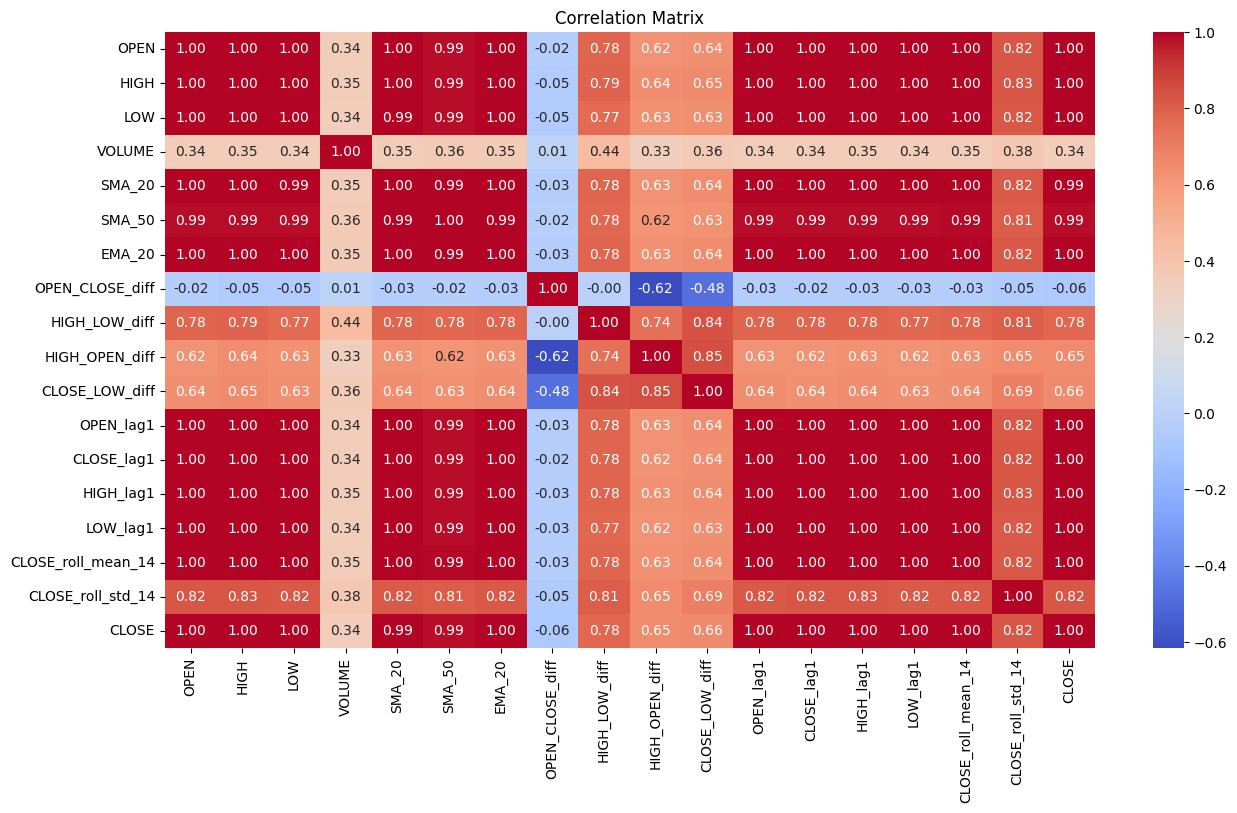

In [65]:
# Compute correlation matrix
correlation_matrix = cleaned_data[features + [target]].corr()

# Visualize correlation
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

**Observations:**

1. **Strong Positive Correlations:**

    * The OPEN, HIGH, LOW, SMA_20, SMA_50, and EMA_20 features exhibit nearly perfect positive correlations with each other (correlation values close   to 1.00). This suggests these features are highly interrelated, likely reflecting the intrinsic nature of stock price trends.
2. **Weak and Negative Correlation:**

    * OPEN_CLOSE_diff shows weak negative correlations with most features, such as HIGH_OPEN_diff (-0.62) and CLOSE_LOW_diff (-0.48). This indicates that the difference between opening and closing prices may not have a direct or significant linear relationship with other metrics in the dataset.

# Model Training

In [70]:
# Define LSTM model using TensorFlow's Keras API
model = Sequential()

# Add an Input layer to specify the shape of the input
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))

# Add LSTM layers and Dropout layers
model.add(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Add an output  layer
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 1, 50)          │        13,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,851 (132.23 KB)

 Trainable params: 33,851 (132.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 293us/step - loss: 0.2025 - val_loss: 0.1307
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0184 - val_loss: 0.0114
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.3594e-04 - val_loss: 9.8861e-04
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.8338e-04 - val_loss: 0.0068
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.6031e-04 - val_loss: 0.0025
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9285e-04 - val_loss: 0.0040
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.3518e-04 - val_loss: 0.0011
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3915e-04 - val_loss: 6.3197e-04
Epoch 10/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2817e-04 - val_loss: 7.7232e-04
Epoch 11/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.1813e-04 - val_loss: 0.0035
Epoch 

# Model Evaluation

In [71]:
# Predict the data
y_pred = model.predict(X_test)

# Inverse transform the scaled predictions and true values
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

# Create a DataFrame to show the actual vs predicted values
results_df = pd.DataFrame({'Actual': y_test_rescaled.flatten(), 'Predicted': y_pred_rescaled.flatten()})

# Display the results in a dataframe
print(results_df.head())
print(results_df.tail())



32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
         Actual     Predicted
0  44324.145659  42106.093750
1  44543.261825  42373.644531
2  46829.192536  44161.660156
3  47109.590033  44339.636719
4  47444.253600  45026.125000
            Actual     Predicted
988   99866.451037  98331.421875
989  101164.789501  97617.585938
990   97406.971588  97264.687500
991   96657.040719  95986.578125
992   97825.205876  95486.492188


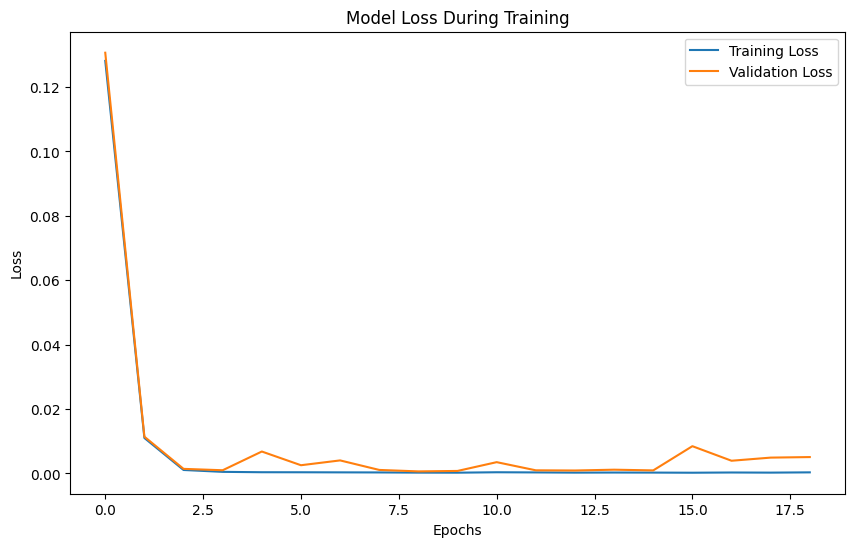

In [72]:
# Plotting the loss and validation loss during training
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Observations:**

1. **Rapid Convergence:** The training and validation loss decrease significantly during the initial epochs, stabilizing close to zero by around the 3rd or 4th epoch, indicating quick learning and effective optimization.

2. **No Overfitting:** The training and validation loss curves are closely aligned throughout the training process, showing consistent performance on both the training and validation sets. This suggests that the model generalizes well to unseen data.


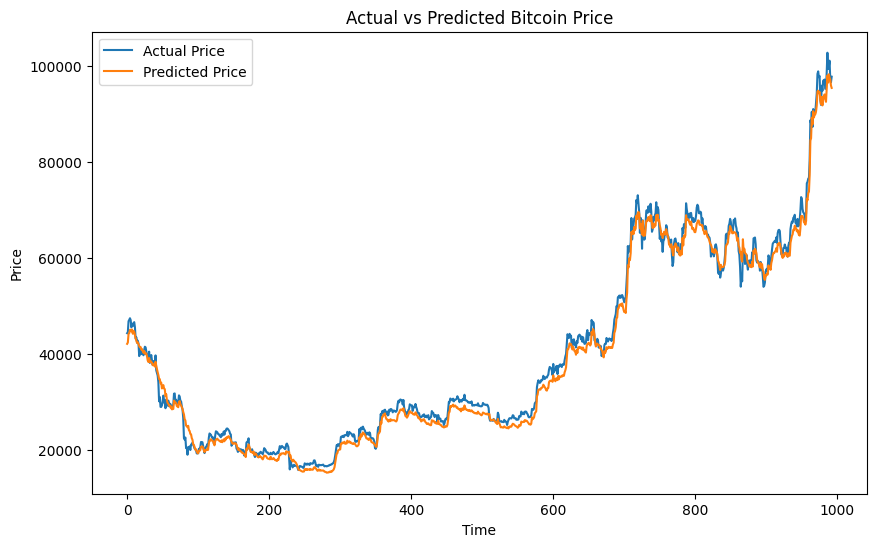

In [73]:
# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled.flatten(), label='Actual Price')
plt.plot(y_pred_rescaled.flatten(), label='Predicted Price')
plt.title('Actual vs Predicted Bitcoin Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

**Observations:**

1. The plot demonstrates a strong correlation between the actual and predicted Bitcoin prices, as the two lines closely follow each other throughout the time series. This indicates that the model has captured the overall trend and fluctuations effectively.

2. Although the predictions align well with the actual data, there are small deviations at certain points, particularly during sharp price changes, where the predicted price lags slightly behind the actual price. This suggests the model may struggle to perfectly capture rapid market movements.

In [75]:
# Evaluate the model
y_pred_rescaled = y_pred_rescaled.flatten()  # Flatten to ensure it's a 1D array
y_test_rescaled = y_test_rescaled.flatten()  # Flatten to ensure it's a 1D array

# Calculate MSE, RMSE, MAE, and R-squared
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mse)  # RMSE is the square root of MSE
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)

# Print the metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R²): {r2}')


Mean Squared Error (MSE): 3016905.5310677034
Root Mean Squared Error (RMSE): 1736.924158121967
Mean Absolute Error (MAE): 1478.2896770828236
R-squared (R²): 0.9925756476184545


**Observations:**

1. **Low Error Metrics:** The MSE (3016905.53) and RMSE (1736.92) are relatively low, indicating that the model predictions are close to the actual values.

2. **Small Average Error:** The MAE (1478.29) shows that, on average, the model's predictions deviate from the actual values by around 1478 units.

3. **High Accuracy:** The R-squared (0.993) indicates that the model explains approximately 99.3% of the variance in the target variable, showcasing excellent performance.